# Character Space

This notebook recreates results discussed in:

- Moretti, Franco. "'Operationalizing': or, the function of measurement in modern literary theory". Stanford Literary Lab Pamphlet 6. 2013

In Moretti's study, he offers several measures of the concept of <i>character space</i>. The simplest of these is to measure the relative dialogue belonging to each character in a play. Presumably the main characters will speak more and peripheral characters will speak less.

The statistical moves we will make here are not only counting the raw number of words spoken by each character, but also normalizing them. That is, converting them into a fraction of all words in the play.

In order to focus on the statistical tasks at hand, we need to parse raw text files to figure out who said what. Unfortunately, that's the hard part!

In [1]:
# Show graphs in notebook
%matplotlib inline

# Import libraries
import pandas as pd  # tabular data analysis library
import numpy as np  # mathematical operations library
import os  # library for manipulating the file system and Bash
from sklearn.feature_extraction.text import CountVectorizer 
import re  # regular expressions library
import matplotlib.pyplot as plt  # plotting base library
import seaborn as sns  # plotting extension library
from bs4 import BeautifulSoup  # html/lxml parsing library
from string import punctuation

# Jean Racine's *Phèdre*

In [2]:
# Read the text of the play from its file on the hard-drive
with open('data/phedre.txt', 'r') as f:
    phedre = f.read()

print(phedre[:200])  # print first 200 characters

ACT I

SCENE I
HIPPOLYTUS, THERAMENES


HIPPOLYTUS
My mind is settled, dear Theramenes,
And I can stay no more in lovely Troezen.
In doubt that racks my soul with mortal anguish,
I grow ashamed of suc


In [3]:
# Create a list, where each entry is a line from the play. We'll split on double line breaks.
# Each line starts with the name of the speaker.
phedre_list = phedre.split('\n\n')

# Create a regex pattern to match words we don't want to start the line
pattern = re.compile(r'ACT|SCENE|Scene')

# Grab list of all the dialogue lines if they don't have the words above in them
phedre_list = [x.strip() for x in phedre_list if re.match(pattern, x) == None and '\n' in x.strip()]

# Print first three dialogue turns
phedre_list[:3]

['HIPPOLYTUS\nMy mind is settled, dear Theramenes,\nAnd I can stay no more in lovely Troezen.\nIn doubt that racks my soul with mortal anguish,\nI grow ashamed of such long idleness.\nSix months and more my father has been gone,\nAnd what may have befallen one so dear\nI know not, nor what corner of the earth\nHides him.',
 "THERAMENES\nAnd where, prince, will you look for him?\nAlready, to content your just alarm,\nHave I not cross'd the seas on either side\nOf Corinth, ask'd if aught were known of Theseus\nWhere Acheron is lost among the Shades,\nVisited Elis, doubled Toenarus,\nAnd sail'd into the sea that saw the fall\nOf Icarus? Inspired with what new hope,\nUnder what favour'd skies think you to trace\nHis footsteps? Who knows if the King, your father,\nWishes the secret of his absence known?\nPerchance, while we are trembling for his life,\nThe hero calmly plots some fresh intrigue,\nAnd only waits till the deluded fair--",
 "HIPPOLYTUS\nCease, dear Theramenes, respect the name\

In [4]:
# Create a dictionary where each key is the name of a character
# and each entry is a single string of words spoken by them

# Initiate empty dict
dialogue_dict = {}

# Iterate through list of turns in the dialogue list
for line in phedre_list:
    
    # Get the name of the character
    char = line.split('\n')[0].split()[0]
    
    # Get the dialogue text
    dialogue = '\n'.join(line.split('\n')[1:])
    
    # Add dialogue text to that character
    if char not in dialogue_dict.keys():
        dialogue_dict[char] = dialogue
    else:
        dialogue_dict[char] += dialogue

        
# Print first 200 character's of Phaedra's dialogue
print(dialogue_dict['PHAEDRA'][:200])

We have gone far enough. Stay, dear Oenone;
Strength fails me, and I needs must rest awhile.
My eyes are dazzled with this glaring light
So long unseen, my trembling knees refuse
Support. Ah me!Ah, ho


In [5]:
def plot_character_space(dialogue):
    
    # Create counter to get all words in all dialogue
    total_words = 0
    for char in dialogue.keys():
        total_words += len(dialogue[char].split())
        
    # Create dict to record share of dialogue for each character
    dialogue_share = {}
    for char in dialogue.keys():
        dialogue_share[char] = len(dialogue[char].split()) / total_words
        
    # Sort values to plot
    values = sorted(dialogue_share.items(), key=lambda x: x[1], reverse=True)
    
    # Plot names and share of dialogue
    sns.barplot([x[0] for x in values], [x[1] for x in values])
    plt.xticks(rotation=90)
    plt.show()

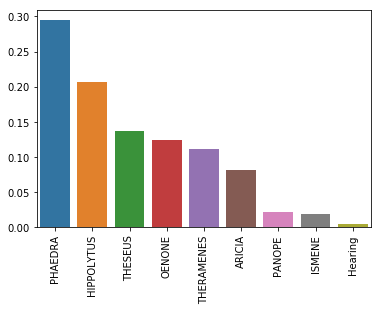

In [6]:
test = plot_character_space(dialogue_dict)

<img src='img/fig1.png' width="66%" height="66%">

# Macbeth

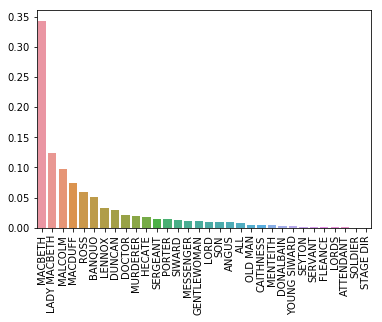

In [7]:
# Read in text
with open('data/macbeth.txt', 'r') as f:
    macbeth = f.read()

# Get cast
pattern = re.compile(r'<[A-Z ]*>')
cast = list(set(re.findall(pattern, macbeth)))
cast = [x.replace('>', '').replace('<', '') for x in cast]

# Make dialogue dict
soup = BeautifulSoup(macbeth, 'lxml')
dialogue_dict = {}
for c in cast:
    dialogue = [x.text for x in soup.find_all(c.lower().split()[0])]
    dialogue = '\n'.join([re.sub(r'<.*>', '', x).strip() for x in dialogue])
    dialogue_dict[c] = dialogue

# Plot
plot_character_space(dialogue_dict)

<img src='img/fig3.png' width="66%" height="66%">

# Othello

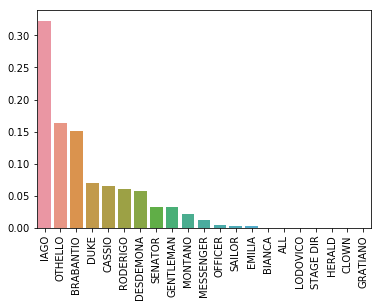

In [8]:
# Read in text
with open('data/othello.txt', 'r') as f:
    othello = f.read()

# Get cast
pattern = re.compile(r'<[A-Z ]*>')
cast = list(set(re.findall(pattern, othello)))
cast = [x.replace('>', '').replace('<', '') for x in cast]

# Make dialogue dict
soup = BeautifulSoup(othello, 'lxml')
dialogue_dict = {}
for c in cast:
    dialogue = [x.text for x in soup.find_all(c.lower().split()[0])]
    dialogue = '\n'.join([re.sub(r'<.*>', '', x).strip() for x in dialogue])
    dialogue_dict[c] = dialogue

# Plot
plot_character_space(dialogue_dict)

<img src='img/fig4.png' width="66%" height="66%">

# Antigone

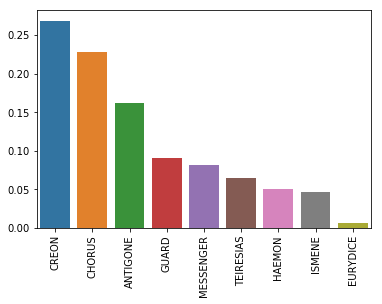

In [9]:
# Read in text
with open('data/antigone.txt', 'r') as f:
    antigone = f.read()

# Split lines
antigone_list = antigone.split('\n\n')

# Make dialogue dict
dialogue_dict = {}
for line in antigone_list:
    dex = line.index(' ')
    char = line[:dex]
    if char not in dialogue_dict.keys():
        dialogue_dict[char] = line[dex:]
    else:
        dialogue_dict[char] += line[dex:]

# Plot
plot_character_space(dialogue_dict)

<img src='img/fig7.png' width="66%" height="66%">

# Operationalizing Tragic Collision

The first thing we'll want to do is create a list of stop words. Stop words are common words in a language that often surface as most common or even most distinctive words, but *allegedly* don't tell us much about meaning. I say *allegedly* because maybe for your interpretation the fact that someone says 'the' much more than another *is* significant.

Moretti is not interested in these, so we need to make a list of words to remove before we can count relative frequencies of words.

In [10]:
# Since we're using an old translation of Antigone,
# Let's supplement our stopword list with their old-timey forms

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

ye_olde_stop_words = ['thou','thy','thee', 'ye', 'hath','hast', 'wilt','aught',\
                      'art', 'dost','doth','shalt','tis','canst','thyself']
stop_words = list(ENGLISH_STOP_WORDS)+ ye_olde_stop_words

print(stop_words)

['off', 'own', 'seemed', 'else', 'amount', 'namely', 'done', 'found', 'must', 'there', 'a', 'us', 'during', 'move', 'six', 'wherein', 'him', 'mill', 'each', 'couldnt', 'everywhere', 'anyone', 'cant', 'also', 'into', 'further', 'do', 'once', 'same', 'via', 'whereupon', 'them', 'whatever', 'behind', 'whoever', 'we', 'under', 'throughout', 'serious', 'become', 'neither', 'across', 'however', 'by', 'first', 'hereby', 'on', 'seems', 'both', 'yourselves', 'will', 'almost', 'whither', 'keep', 'yourself', 'of', 'ie', 'afterwards', 'and', 'against', 'as', 'becoming', 'nevertheless', 'nowhere', 'one', 'together', 'until', 'when', 'where', 'seem', 'then', 'thereupon', 'would', 'fifty', 'nor', 'back', 'if', 'before', 'about', 'it', 'onto', 'eg', 'or', 'sometimes', 'is', 'might', 'thereby', 'most', 'although', 'un', 'last', 'bill', 'only', 'alone', 'meanwhile', 'per', 'whom', 'but', 'all', 'nine', 'often', 'myself', 'beside', 'besides', 'inc', 'part', 'in', 'two', 'am', 'why', 'always', 'anyway', '

# Most Distinctive Words

The code below looks complicated, but all it does is count how many times each character said each word in the entire text. If the character didn't say the word, it just gets tallied as a 0. We then sum all of these counts to get the number of times each word is spoken in the text. If we're intested in the most distinctive words, we'd want to know how many times a character said a words compared to how many times it was spoken in the entire text. We'll make an 'EXPECTED' column that tells us if the word was distributed evenly amongst characters, how many times our target character should have said it. Then we'll add a column for the ratio between the observed occurences and the expected occurences.

**TLDR: This code will tell us which words a specific character used more or less frequently than average for a character in a text.**

In [11]:
def get_mdw(dialogue_dict, character, group=False):
    # Boot up the dtm-maker
    cv = CountVectorizer()

    # Create the dtm
    dtm = cv.fit_transform(dialogue_dict.values())

    # Put the dtm into human-readable format
    word_list = cv.get_feature_names()
    dtm_df = pd.DataFrame(dtm.toarray(), columns = word_list, index = dialogue_dict.keys())

    # Create new dataframe
    mdw_df = pd.DataFrame()

    # Add a column for her observed word counts
    mdw_df[character] = dtm_df.loc[character]

    if group == False:
        # Add a column for the total counts of each word in the play
        mdw_df['WORD_TOTAL'] = dtm_df.sum()
    else:
        # Add a column for the total counts of each word for the characters in the defined group
        mdw_df['WORD_TOTAL'] = dtm_df.loc[group].sum()

    # Calculate Antigone's share of the total dialogue
    char_space = sum(mdw_df[character])/float(sum(mdw_df['WORD_TOTAL']))

    # Add a new column in which we calculate an "expected" number of times
    # Antigone would utter each word, based on its overall use in the play
    # and her share of the dialogue.

    mdw_df[character + '_EXPECTED'] = mdw_df['WORD_TOTAL']*char_space

    # How much more/less frequently does Antigone use the word than expected?
    mdw_df['OBS-EXP_RATIO'] = mdw_df[character]/(mdw_df[character + '_EXPECTED'])
    
    # Sort the dataframe by the Observed/Expected Ratio to show 
    # Antigone's 20 "Most Distinctive Words"
    return mdw_df[(mdw_df['OBS-EXP_RATIO']>1)&(mdw_df['WORD_TOTAL']>5)].sort_values('OBS-EXP_RATIO', ascending=False).head(20)

In [12]:
get_mdw(dialogue_dict, 'ANTIGONE')

,ANTIGONE,WORD_TOTAL,ANTIGONE_EXPECTED,OBS-EXP_RATIO
brother,10,14,2.234963,4.474348
aught,4,6,0.957841,4.176058
suffer,4,7,1.117481,3.579478
mother,7,14,2.234963,3.132043
nor,7,14,2.234963,3.132043
home,3,6,0.957841,3.132043
heaven,3,6,0.957841,3.132043
knew,3,6,0.957841,3.132043
mine,12,24,3.831365,3.132043
another,3,6,0.957841,3.132043


In [13]:
get_mdw(dialogue_dict, 'CREON')

,CREON,WORD_TOTAL,CREON_EXPECTED,OBS-EXP_RATIO
let,7,9,2.424587,2.887090
sayest,6,8,2.155188,2.783980
woman,8,11,2.963384,2.699617
your,6,9,2.424587,2.474649
dost,8,12,3.232782,2.474649
lead,4,6,1.616391,2.474649
grave,4,6,1.616391,2.474649
ye,16,26,7.004361,2.284291
friend,5,9,2.424587,2.062207
woe,8,15,4.040978,1.979719


Here's what Moretti had as most distinctive words:

<img src='img/mdw-nouns.png' width="66%" height="66%">
<img src='img/mdw-verbs.png' width="66%" height="66%">

But Moretti notes that these are Antigone's and Creon's most distinctive words as compared to the rest of the text (al the characters in the text). What we are interested in only the relationship between the two characters? We can look at the most distinctive words given the dialogue of only Antigone and Creon the same way, just leaving out the rest of the dialogue:

In [14]:
get_mdw(dialogue_dict, 'ANTIGONE', group=['ANTIGONE', 'CREON'])

,ANTIGONE,WORD_TOTAL,ANTIGONE_EXPECTED,OBS-EXP_RATIO
nor,7,8,2.976705,2.351594
mother,7,8,2.976705,2.351594
brother,10,13,4.837145,2.067335
could,6,8,2.976705,2.015652
whom,5,7,2.604617,1.919668
suffer,4,6,2.232529,1.791690
share,4,6,2.232529,1.791690
last,4,6,2.232529,1.791690
die,4,6,2.232529,1.791690
go,4,6,2.232529,1.791690


In [15]:
get_mdw(dialogue_dict, 'CREON', group=['ANTIGONE', 'CREON'])

,CREON,WORD_TOTAL,CREON_EXPECTED,OBS-EXP_RATIO
sayest,6,6,3.767471,1.592580
she,16,16,10.046590,1.592580
woman,8,8,5.023295,1.592580
woe,8,8,5.023295,1.592580
let,7,7,4.395383,1.592580
we,8,9,5.651207,1.415627
dost,8,9,5.651207,1.415627
evil,7,8,5.023295,1.393508
man,13,15,9.418679,1.380236
even,6,7,4.395383,1.365069


Here's what Moretti had:

<img src='img/mdw-2.png' width="66%" height="66%">

## Challenge

Experiment with looking at the most distinctive words for characters in the other plays we looked at (*Phèdre* and *Macbeth*)

In [16]:
## YOUR CODE HERE


If you've already taken Data 8, or your Python text parsing skills are already advanced, try this one:

I've placed two more text files in the data folder for the two remaining dramas Moretti plots: Friedrich Schiller's *Don Carlos* and Henrik Ibsen's *Ghosts*. Write some code to plot the character space!

In [17]:
!ls data

antigone.txt  ghosts.txt    othello.txt
doncarlos.txt macbeth.txt   phedre.txt


In [18]:
## YOUR CODE HERE


<img src='img/fig5.png' width="66%" height="66%">

<img src='img/fig6.png' width="66%" height="66%">